# 2D Classical Ising Model
## $2^N \times 2^N$ Lattice

## Set up the working environment

In [1]:
# import libraries
import numpy as np
import pyuni10 as uni10
import matplotlib.pyplot as plt

## Define numpy array to represent matrixes

In [2]:
# matrixes

# def mat_W(beta):
#     """Create W matrix (Boltzman weight)
#     """
#     W = np.array([[np.exp(+beta), np.exp(-beta)],
#                   [np.exp(-beta), np.exp(+beta)]])
#     return W

def mat_W(beta, h):
    """Create W matrix (Boltzman weight)
    """
    W = np.array([[np.exp(+beta+beta*h), np.exp(-beta)],
                  [np.exp(-beta), np.exp(+beta-beta*h)]])
    return W

def mat_M0(beta):
    M = np.array([[np.sqrt(np.cosh(beta)), np.sqrt(np.sinh(beta))],
                  [np.sqrt(np.cosh(beta)), -np.sqrt(np.sinh(beta))]])
    return M

def mat_M(beta, h):
    W = mat_W(beta, h)
    U, S, Vd = np.linalg.svd(W)
    if U[0, 0] < 0 :
        U = -U
        Vd = -Vd
    M = U @ np.diag( np.sqrt(S) )
    return M

def mat_T(beta, h):
    T = np.zeros((2,2,2,2))
    M = mat_M(beta, h)
    for i in range(1+1):
        for j in range(1+1):
            for k in range(1+1):
                for l in range(1+1):
                    T[i,j,k,l] = M[0,i]*M[0,j]*M[0,k]*M[0,l]+M[1,i]*M[1,j]*M[1,k]*M[1,l]
    T = T.reshape((4,4))
    return T
# print(mat_T(1.0, 0.0))

def delta_M():
    delta = np.zeros((4, 4))
    delta[0, 0] = 1.0
    delta[3, 3] = 1.0
    return delta

def Sz_M():
    Sz = np.zeros((4, 4))
    Sz[0, 0] = 1.0
    Sz[3, 3] = -1.0
    return Sz
# print(Sz_M())

## Define in-bonds and out-bonds (of dimension 2)
## Define tensors which are indepdent of T and h

In [3]:
# bonds
ket = uni10.Bond(uni10.BD_IN,2)
bra = uni10.Bond(uni10.BD_OUT,2)

# tensors (temperature and field independent)

# delta tensor
delta = uni10.UniTensorR([ket,ket,bra,bra])
delta.SetName('delta')
delta.PutBlock(delta_M())
delta.SetLabel([10,11,12,13])
# print(delta)

# Sz tensor
Sz = uni10.UniTensorR([ket,ket,bra,bra])
Sz.SetName('Sz')
Sz.PutBlock(Sz_M())
# print(Sz)

# Construct bare tensors for the partition function and expectation values

In [4]:
def bare_tensor(beta, h):
    # M & MT
    M = uni10.UniTensorR([ket, bra])
    M.SetName('M')
    M.PutBlock(mat_M(beta, h))
#     print(M)
    M.SetName('MT')
    MT = uni10.Transpose(M)
#     print(MT)

    # T 
    T = uni10.UniTensorR([ket,ket,bra,bra])
    T.SetName('T')
    net = uni10.Network("W2T.net")
    net.PutTensor("delta", delta)
    net.PutTensor("M",M)
    net.PutTensor("MT",MT)
    net.Launch(T)
#     print(T)

    # Tz
    Tz = uni10.UniTensorR([ket,ket,bra,bra])
    net = uni10.Network("W2T.net")
    net.PutTensor("delta", Sz)
    net.PutTensor("M",M)
    net.PutTensor("MT",MT)
    net.Launch(Tz)
    Tz.SetName('Tz')
#     print(Tz)
    return T, Tz

# 2x2 lattice

## Analytical results for h=0

In [5]:
def exact(beta):
    Z = 2*np.exp(8*beta)+12+2*np.exp(-8*beta)
    F = -np.log(Z)/beta
    E = -(2*8*np.exp(8*beta)+2*(-8)*np.exp(-8*beta))/Z
    E_sqr = (2*64*np.exp(8*beta) +2*64*np.exp(-8*beta))/Z
    C = (E_sqr-E*E)*(beta*beta)
    M_abs = (2*4*np.exp(8*beta)+8*2)/Z
    M_sqr = (2*16*np.exp(8*beta)+8*4)/Z
    chi_p = (M_sqr-M_abs*M_abs)*beta
    
    return Z, F, E, E_sqr, C, M_abs, M_sqr, chi_p

## Perform tensor contraction on 2X2 lattice
### enrgy per bond = -J*(SzSz)

In [6]:
def contract_Z(T):
    # Z
    net = uni10.Network("trace.net")
    Z = uni10.UniTensorR()
    net.PutTensor('T11',T)
    net.PutTensor('T12',T)
    net.PutTensor('T21',T)
    net.PutTensor('T22',T)
    net.Launch(Z)
    Z = Z.GetBlock(0)[0,0]
    return Z

def contract_SzSz(T11, T12, T21, T22):
    # SzSz
    net = uni10.Network("trace.net")
    SzSz = uni10.UniTensorR()
    net.PutTensor('T11',T11)
    net.PutTensor('T12',T12)
    net.PutTensor('T21',T21)
    net.PutTensor('T22',T22)
    net.Launch(SzSz)
    SzSz = SzSz.GetBlock(0)[0,0]
#     print(SzSz)
    return SzSz

def contract_Cmax(T, Tz):
    # Cmax
    net = uni10.Network("trace.net")
    Cmax = uni10.UniTensorR()
    net.PutTensor('T11',Tz)
    net.PutTensor('T12',T)
    net.PutTensor('T21',T)
    net.PutTensor('T22',Tz)
    net.Launch(Cmax)
    Cmax = Cmax.GetBlock(0)[0,0]
#     print(Cmax)
    return Cmax

def contract_m(T, Tz):
    # m
    net = uni10.Network("trace.net")
    m = uni10.UniTensorR()
    net.PutTensor('T11',Tz)
    net.PutTensor('T12',T)
    net.PutTensor('T21',T)
    net.PutTensor('T22',T)
    net.Launch(m)
    m = m.GetBlock(0)[0,0]
#     print(m)
    return m

T, Tz = bare_tensor(2.0, 0.0)
Z = contract_Z(T)
SzSz = contract_SzSz(Tz, Tz, T, T)
Cmax = contract_Cmax(T, Tz)
m = contract_m(T, Tz)
print(Z, Z/Z)
print(SzSz, SzSz/Z)
print(Cmax, Cmax/Z)
print(m, m/Z)
print(exact(2.0))

17772233.041016012 1.0
17772221.041015565 0.9999993247893825
17772217.041016016 0.9999990997192103
4.814642282973439e-08 2.7090812234241293e-15
(17772233.041015968, -8.34657392788539, -7.99999459831506, 63.999956786522084, 0.00017285380781117965, 3.99999819943837, 15.9999909971919, 1.0803363394984444e-05)


## Energy per bond

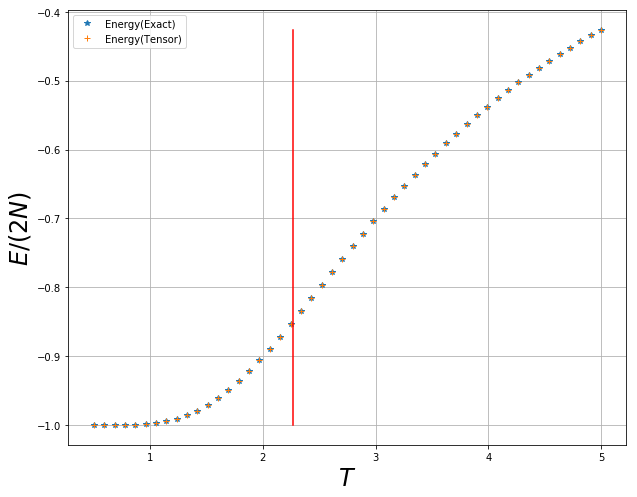

In [7]:
N = 4
plt.figure(figsize=(10,8))
Temp = np.linspace(0.5, 5, 50)
beta = 1.0/Temp
Tc = 2/np.log(1+np.sqrt(2))

Z, F, E, E_sqr, C, M_abs, M_sqr, chi_p = exact(beta)
plt.plot(Temp, E/(2*N), '*', label='Energy(Exact)')

h = 0
Z = np.zeros_like(beta)
SzSz = np.zeros_like(beta)
Cmax = np.zeros_like(beta)
m = np.zeros_like(beta)

for i in range(beta.size):
#     Z[i], SzSz[i], Cmax[i], m[i] = contract(beta[i], h)
    T, Tz = bare_tensor(beta[i], h)
    Z[i] = contract_Z(T)
    SzSz[i] = contract_SzSz(Tz, Tz, T, T)

E_2N = -SzSz/Z
plt.plot(Temp, E_2N, '+', label='Energy(Tensor)')
plt.plot([Tc, Tc], [np.min(-SzSz/Z),np.max(-SzSz/Z)], 'r')
plt.legend()
plt.grid()
plt.xlabel(r'$T$', fontsize=24)
plt.ylabel(r'$E/(2N)$', fontsize=24)
plt.show()

## Specific heat per site

Text(0, 0.5, '$C/N$')

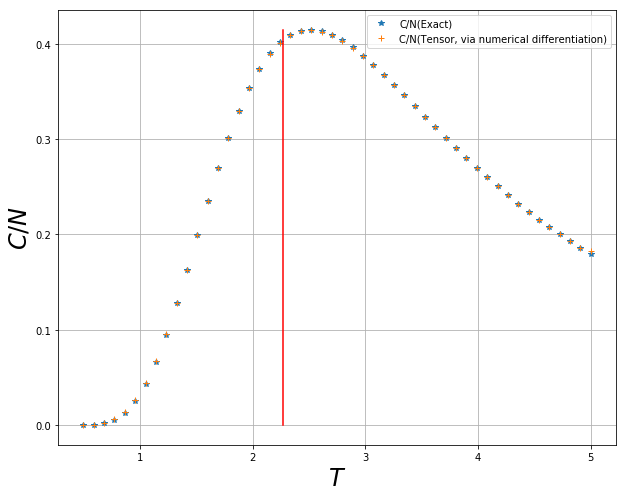

In [8]:
N = 4
plt.figure(figsize=(10,8))
Temp = np.linspace(0.5, 5, 50)
beta = 1.0/Temp
Tc = 2/np.log(1+np.sqrt(2))

Z, F, E, E_sqr, C, M_abs, M_sqr, chi_p = exact(beta)
plt.plot(Temp, C/N, '*', label='C/N(Exact)')

h = 0
Z = np.zeros_like(beta)
SzSz = np.zeros_like(beta)
Cmax = np.zeros_like(beta)
m = np.zeros_like(beta)

for i in range(beta.size):
#     Z[i], SzSz[i], Cmax[i], m[i] = contract(beta[i], h)
    T, Tz = bare_tensor(beta[i], h)
    Z[i] = contract_Z(T)
    SzSz[i] = contract_SzSz(Tz, Tz, T, T)
    Cmax[i] = contract_Cmax(T, Tz)
    m[i] = contract_m(T, Tz)
    
E = -8*SzSz/Z
C = np.gradient(E, Temp)

plt.plot(Temp, C/N, '+', label='C/N(Tensor, via numerical differentiation)')
plt.plot([Tc, Tc], [np.min(C/N),np.max(C/N)], 'r')
plt.legend()
plt.grid()
plt.xlabel(r'$T$', fontsize=24)
plt.ylabel(r'$C/N$', fontsize=24)

## Use Cmax to approximate $m^2$

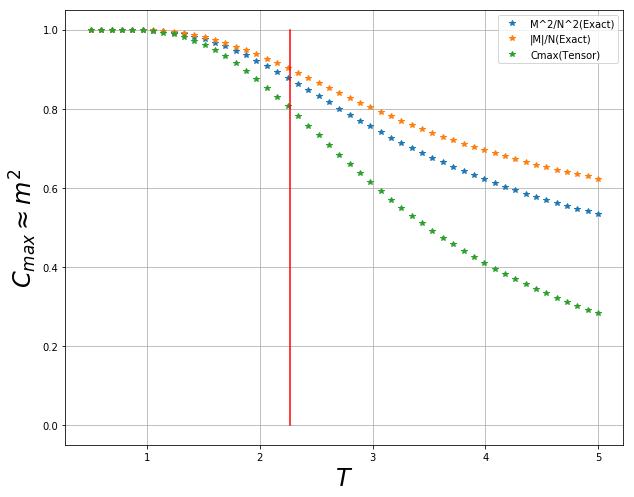

In [9]:
N = 4
plt.figure(figsize=(10,8))
Temp = np.linspace(0.5, 5, 50)
beta = 1.0/Temp
Tc = 2/np.log(1+np.sqrt(2))

Z, F, E, E_sqr, C, M_abs, M_sqr, chi_p = exact(beta)
plt.plot(Temp, M_sqr/N**2, '*', label='M^2/N^2(Exact)')
plt.plot(Temp, M_abs/N, '*', label='|M|/N(Exact)')


h = 0
Z = np.zeros_like(beta)
SzSz = np.zeros_like(beta)
m = np.zeros_like(beta)
Cmax = np.zeros_like(beta)

for i in range(beta.size):
#     Z[i], SzSz[i], Cmax[i], m[i] = contract(beta[i], h)
    T, Tz = bare_tensor(beta[i], h)
    Z[i] = contract_Z(T)
    Cmax[i] = contract_Cmax(T, Tz)
    
plt.plot(Temp, Cmax/Z, '*', label='Cmax(Tensor)')
plt.plot([Tc, Tc], [0,1], 'r')
plt.legend()
plt.grid()
plt.xlabel(r'$T$', fontsize=24)
plt.ylabel(r'$C_{max}\approx m^2$', fontsize=24)
plt.show()

## $\frac{dC_{max}}{dT}$

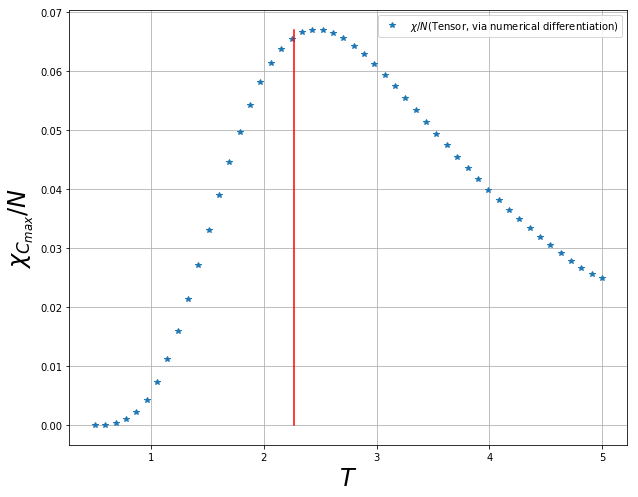

In [10]:
N = 4
plt.figure(figsize=(10,8))
Temp = np.linspace(0.5, 5, 50)
beta = 1.0/Temp
Tc = 2/np.log(1+np.sqrt(2))

h = 0
Z = np.zeros_like(beta)
SzSz = np.zeros_like(beta)
m = np.zeros_like(beta)
Cmax = np.zeros_like(beta)

for i in range(beta.size):
#     Z[i], SzSz[i], Cmax[i], m[i] = contract(beta[i], h)
    T, Tz = bare_tensor(beta[i], h)
    Z[i] = contract_Z(T)
    Cmax[i] = contract_Cmax(T, Tz)

chi = -np.gradient(Cmax/Z, Temp)
plt.plot(Temp, chi/N, '*', label=r'$\chi/N$(Tensor, via numerical differentiation)')
plt.plot([Tc, Tc], [np.min(chi/N),np.max(chi/N)], 'r')
plt.legend()
plt.grid()
plt.xlabel(r'$T$', fontsize=24)
plt.ylabel(r'$\chi_{C_{max}}/N$', fontsize=24)
plt.show()

## Magnetization with external field

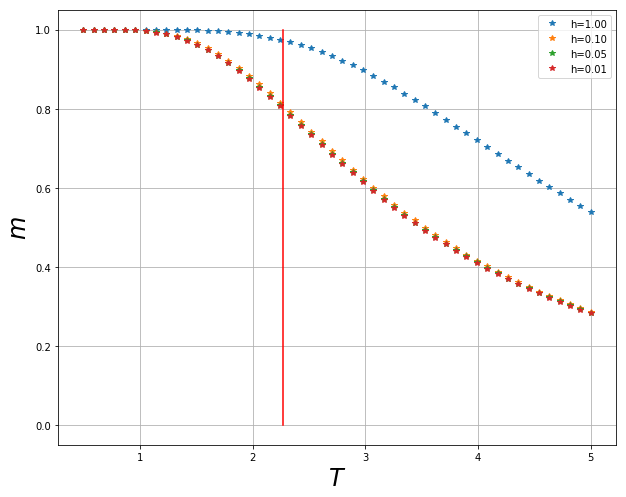

In [11]:
N = 4
plt.figure(figsize=(10,8))
Temp = np.linspace(0.5, 5, 50)
beta = 1.0/Temp
Tc = 2/np.log(1+np.sqrt(2))

Z = np.zeros_like(beta)
SzSz = np.zeros_like(beta)
m = np.zeros_like(beta)
Cmax = np.zeros_like(beta)

h = 1
for i in range(beta.size):
    T, Tz = bare_tensor(beta[i], h)
    Z[i] = contract_Z(T)
    m[i] = contract_Cmax(T, Tz)    
plt.plot(Temp, m/Z, '*', label='h=1.00')

h = 0.1
for i in range(beta.size):
    T, Tz = bare_tensor(beta[i], h)
    Z[i] = contract_Z(T)
    m[i] = contract_Cmax(T, Tz)    
plt.plot(Temp, m/Z, '*', label='h=0.10')

h = 0.05
for i in range(beta.size):
    T, Tz = bare_tensor(beta[i], h)
    Z[i] = contract_Z(T)
    m[i] = contract_Cmax(T, Tz)    
plt.plot(Temp, m/Z, '*', label='h=0.05')

h = 0.01
for i in range(beta.size):
    T, Tz = bare_tensor(beta[i], h)
    Z[i] = contract_Z(T)
    m[i] = contract_Cmax(T, Tz)    
plt.plot(Temp, m/Z, '*', label='h=0.01')

plt.plot([Tc, Tc], [0,1], 'r')
plt.legend()
plt.grid()
plt.xlabel(r'$T$', fontsize=24)
plt.ylabel(r'$m$', fontsize=24)
plt.show()

## Tensor RG

In [12]:
# decompose a rank-4 tensor T into two rank-3 tensor S
# current version assume all legs of T have the same dimension
def T2LURD(T, D_cut):
    # S_LU and S_RD
    TM = T.GetBlock()
    D_cut = min(D_cut, TM.shape[0])
#     print(D_cut)
#     print('TM=\n',TM)
    U,Sigma,Vd = np.linalg.svd(TM)
    
    U_cut = U[:,:D_cut]
#     print('U_cut=\n',U_cut)
    Sigma_cut = Sigma[:D_cut]
#     print('Sigma_cut=\n',Sigma_cut)
    Vd_cut = Vd[:D_cut,:]
#     print('Vd_cut=\n',Vd_cut)

    bra = uni10.Bond(uni10.BD_OUT, D_cut)
    ket = uni10.Bond(uni10.BD_IN, D_cut)
 
    S_LU = uni10.UniTensorR([T.bond(0), T.bond(1), bra])
    S_LU.SetLabel([T.label(0),T.label(1),10])
#     print(S_LU)
    S_LU.PutBlock( U_cut @ np.diag(np.sqrt(Sigma_cut)))
    
    S_RD = uni10.UniTensorR([ket, T.bond(2), T.bond(3)])
    S_RD.SetLabel([10,T.label(2),T.label(3)])
    S_RD.PutBlock( np.diag(np.sqrt(Sigma_cut)) @ Vd_cut)   

#     print(S_LU, S_RD)
    diff = uni10.Contract(S_LU, S_RD)-T
#     print("err=", np.max(diff.GetBlock()))
    return S_LU, S_RD

def T2LDRU(T, D_cut):
    # S_LD and S_RU
    # permute legs of T before SVD
    TP = uni10.UniTensorR(T)
    uni10.Permute(TP, [T.label(1),T.label(3),T.label(0),T.label(2)], 2)
    TM = TP.GetBlock()
    D_cut = min(D_cut, TM.shape[0])    
#     print('TM=\n',TM)
    U,Sigma,Vd = np.linalg.svd(TM)
    
    U_cut = U[:,:D_cut]
#     print('U_cut=\n',U_cut)
    Sigma_cut = Sigma[:D_cut]
#     print('Sigma_cut=\n',Sigma_cut)
    Vd_cut = Vd[:D_cut,:]
#     print('Vd_cut=\n',Vd_cut)

    bra = uni10.Bond(uni10.BD_OUT, D_cut)
    ket = uni10.Bond(uni10.BD_IN, D_cut)
 
    S_LD = uni10.UniTensorR([TP.bond(0), TP.bond(1), bra])
    S_LD.SetLabel([TP.label(0),TP.label(1),10])
    S_LD.PutBlock( U_cut @ np.diag(np.sqrt(Sigma_cut)))
    
    S_RU = uni10.UniTensorR([ket, TP.bond(2), TP.bond(3)])
    S_RU.SetLabel([10,TP.label(2),TP.label(3)])
    S_RU.PutBlock( np.diag(np.sqrt(Sigma_cut)) @ Vd_cut)    
    
    # permute legs of S    
#     print(S_LD, S_RU)
    diff = uni10.Contract(S_LD, S_RU)-TP
#     print("err=", np.max(diff.GetBlock()))
    return S_LD, S_RU

# T, Tz = bare_tensor(2.0, 0.0)
T = uni10.UniTensorR([ket, ket, bra, bra])
T.SetName('T')
T.SetRawElem(np.array(range(16)))

# print(T)
# S_LU, S_RD = T2LURD(T, 4)
# print(S_LU, S_RD)
# print(uni10.Contract(S_LU, S_RD))

# TP = uni10.Permute(T, [1,3,0,2], 2)
# print(TP)
# T.SetLabel([2,3,4,5])
S_LD, S_RU = T2LDRU(T, 4)
# print(uni10.Contract(S_LD, S_RU)-TP)

In [13]:
# contract four S tensors into a renormalized T tensor
def SSSS2T(S_RD, S_LD, S_RU, S_LU):
    T = uni10.UniTensorR([S_RD.bond(0),S_RU.bond(0),S_LD.bond(2),S_LU.bond(2)])
    net = uni10.Network('SSSS2T.net')
    net.PutTensor('S_RD', S_RD)
    net.PutTensor('S_LD', S_LD)
    net.PutTensor('S_RU', S_RU)
    net.PutTensor('S_LU', S_LU)
    net.Launch(T)
#     print(T)
    return T

In [14]:
def half_RG(T, T11, T12, T21, T22, Dcut):        
    # first-half
    S_LD, S_RU = T2LDRU(T, Dcut)
    S_LU, S_RD = T2LURD(T, Dcut)
    
    # impurity tensors
    S11_LD, S11_RU = T2LDRU(T11, Dcut)
    S22_LD, S22_RU = T2LDRU(T22, Dcut)
    S12_LU, S12_RD = T2LURD(T12, Dcut)
    S21_LU, S21_RD = T2LURD(T21, Dcut)

    # RG of T
    TT = SSSS2T(S_RD, S_LD, S_RU, S_LU)

    # RG of T11
    TT11 = SSSS2T(S_RD, S11_LD, S_RU, S21_LU)
    TT22 = SSSS2T(S12_RD, S_LD, S22_RU, S_LU)
    TT12 = SSSS2T(S_RD, S_LD, S11_RU, S12_LU)
    TT21 = SSSS2T(S21_RD, S22_LD, S_RU, S_LU)
    
    # rescale
    Tmax = np.max(TT.GetBlock())
    TT = (1/Tmax)*TT
    TT11 = (1/Tmax)*TT11  
    TT12 = (1/Tmax)*TT12
    TT21 = (1/Tmax)*TT21
    TT22 = (1/Tmax)*TT22
    
    return TT, TT11, TT12, TT21, TT22

In [15]:
Temp = 5
beta = 1.0/Temp
print('Temp=',Temp)

T, Tz = bare_tensor(beta, 0.0)

T11 = Tz
T12 = Tz
T21 = T
T22 = T

Z = contract_Z(T)
SzSz = contract_SzSz(T11, T12, T21, T22)
print('2x2')
print('Z={:16.16e}'.format(Z))
print('SzSz={:16.16e}'.format(SzSz))
print('E={:16.16e}'.format((-2*SzSz/Z)))
print('E={:16.16e}'.format(exact(beta)[2]/4))

Dcut = 16
TT, TT11, TT12, TT21, TT22 = half_RG(T, T11, T12, T21, T22, Dcut)
T, T11, T12, T21, T22 = half_RG(TT, TT11, TT12, TT21, TT22, Dcut)

Z1 = contract_Z(T)
SzSz1 = contract_SzSz(T11, T12, T21, T22)
print('4x4')
print('Z={:16.16e}'.format(Z1))
print('SzSz={:16.16e}'.format(SzSz1))
print('E={:16.16e}'.format((-2*SzSz1/Z1)))

TT, TT11, TT12, TT21, TT22 = half_RG(T, T11, T12, T21, T22, Dcut)
T, T11, T12, T21, T22 = half_RG(TT, TT11, TT12, TT21, TT22, Dcut)

Z2 = contract_Z(T)
SzSz2 = contract_SzSz(T11, T12, T21, T22)
print('8x8')
print('Z={:16.16e}'.format(Z2))
print('SzSz={:16.16e}'.format(SzSz2))
print('E={:16.16e}'.format((-2*SzSz2/Z2)))



Temp= 5
2x2
Z=2.2309857884779476e+01
SzSz=9.5022718128008936e+00
E=-8.5184512262479795e-01
E=-8.5184512262479772e-01
4x4
Z=1.0376616019161213e+00
SzSz=2.3665707912521738e-01
E=-4.5613536954284911e-01
8x8
Z=1.0075073446552687e+00
SzSz=2.1579198280093942e-01
E=-4.2836805894407720e-01


In [21]:
h = 0
Tc = 2/np.log(1+np.sqrt(2))

Temp = np.linspace(0.5, 5, 50)
beta = 1.0/Temp

NSize = 6

Z = np.zeros((beta.size, NSize))
SzSz = np.zeros((beta.size, NSize))

Dcut = 16
for b in range(beta.size):
    T, Tz = bare_tensor(beta[b], h)
    T11 = Tz
    T12 = Tz
    T21 = T
    T22 = T

    for s in range(NSize):
        Z[b, s] = contract_Z(T)
        SzSz[b, s] = contract_SzSz(T11, T12, T21, T22)
        
        TT, TT11, TT12, TT21, TT22 = half_RG(T, T11, T12, T21, T22, Dcut)
        T, T11, T12, T21, T22 = half_RG(TT, TT11, TT12, TT21, TT22, Dcut)

E = -2*SzSz/Z
print(E)

[[-1.99999865 -1.9999991  -1.9999991  -1.9999991  -1.9999991  -1.9999991 ]
 [-1.99998383 -1.99998918 -1.99998918 -1.99998918 -1.99998918 -1.99998918]
 [-1.99990063 -1.99993317 -1.99993317 -1.99993317 -1.99993317 -1.99993317]
 [-1.9996028  -1.99973048 -1.9997305  -1.9997305  -1.9997305  -1.9997305 ]
 [-1.99881638 -1.99918609 -1.99918623 -1.99918623 -1.99918623 -1.99918623]
 [-1.99713982 -1.99799695 -1.99799782 -1.99799782 -1.99799782 -1.99799782]
 [-1.99408073 -1.99575566 -1.99575968 -1.99575968 -1.99575968 -1.99575968]
 [-1.98911366 -1.99196254 -1.9919774  -1.9919774  -1.9919774  -1.9919774 ]
 [-1.98174087 -1.9860373  -1.98608267 -1.98608267 -1.98608267 -1.98608267]
 [-1.97154372 -1.97732543 -1.97744302 -1.97744305 -1.97744305 -1.97744305]
 [-1.95821832 -1.96510018 -1.96536261 -1.96536283 -1.96536283 -1.96536283]
 [-1.94159399 -1.94856677 -1.94907133 -1.94907271 -1.94907272 -1.94907272]
 [-1.92163598 -1.92688035 -1.92769815 -1.92770502 -1.92770503 -1.92770503]
 [-1.89843579 -1.89919125

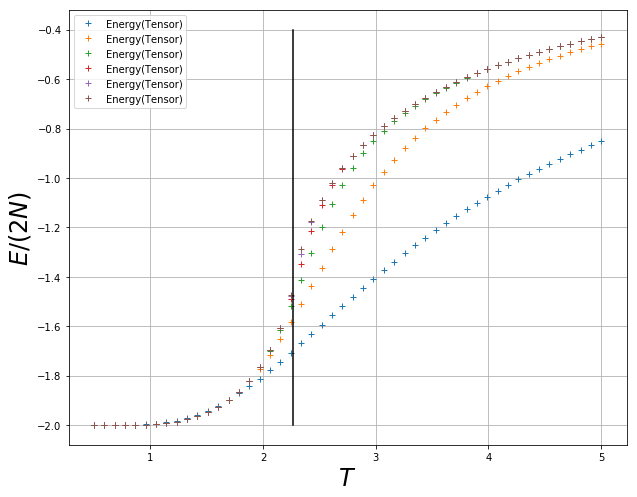

In [22]:
plt.figure(figsize=(10,8))

for s in range(NSize):
    plt.plot(Temp, E[:,s], '+', label='Energy(Tensor)')

plt.plot([Tc, Tc], [-2, -0.4], 'k')
plt.legend()
plt.grid()
plt.xlabel(r'$T$', fontsize=24)
plt.ylabel(r'$E/(2N)$', fontsize=24)
plt.show()

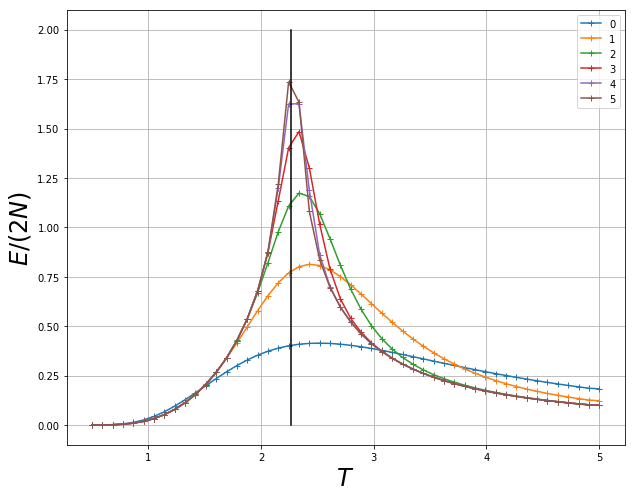

In [23]:
plt.figure(figsize=(10,8))

C = np.zeros_like(E)

for s in range(NSize):
    C[:,s] = np.gradient(E[:,s], Temp)
    plt.plot(Temp, C[:,s], '+-',label='{:d}'.format(s))

plt.plot([Tc, Tc], [0, 2], 'k')
plt.legend()
plt.grid()
plt.xlabel(r'$T$', fontsize=24)
plt.ylabel(r'$E/(2N)$', fontsize=24)
plt.show()

In [24]:
Temp_0 = Temp
C_0 = C

In [25]:
h = 0
Tc = 2/np.log(1+np.sqrt(2))

Temp = np.linspace(2, 3, 50)
beta = 1.0/Temp

NSize = 6

Z = np.zeros((beta.size, NSize))
SzSz = np.zeros((beta.size, NSize))

Dcut = 16
for b in range(beta.size):
    T, Tz = bare_tensor(beta[b], h)
    T11 = Tz
    T12 = Tz
    T21 = T
    T22 = T

    for s in range(NSize):
        Z[b, s] = contract_Z(T)
        SzSz[b, s] = contract_SzSz(T11, T12, T21, T22)
        
        TT, TT11, TT12, TT21, TT22 = half_RG(T, T11, T12, T21, T22, Dcut)
        T, T11, T12, T21, T22 = half_RG(TT, TT11, TT12, TT21, TT22, Dcut)

E = -2*SzSz/Z
# print(E)

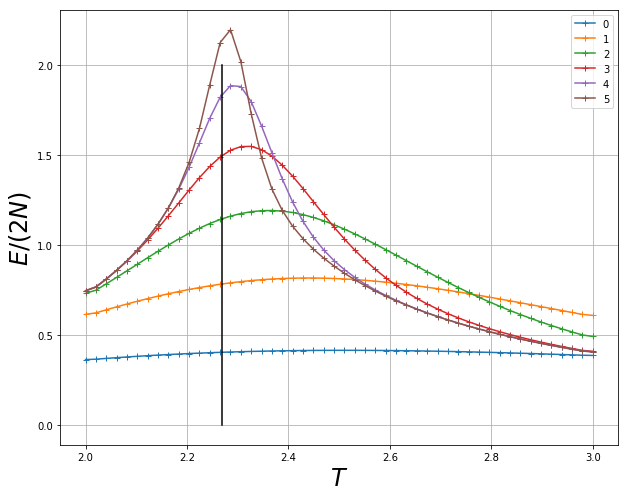

In [26]:
plt.figure(figsize=(10,8))

C = np.zeros_like(E)

for s in range(NSize):
    C[:,s] = np.gradient(E[:,s], Temp)
    plt.plot(Temp, C[:,s], '+-',label='{:d}'.format(s))

plt.plot([Tc, Tc], [0, 2], 'k')
plt.legend()
plt.grid()
plt.xlabel(r'$T$', fontsize=24)
plt.ylabel(r'$E/(2N)$', fontsize=24)
plt.show()

In [27]:
Temp_1 = Temp
C_1 = C

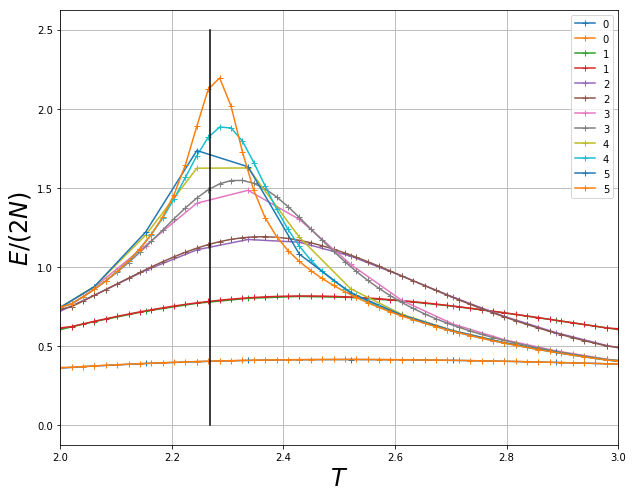

In [28]:
plt.figure(figsize=(10,8))

for s in range(NSize):
    plt.plot(Temp_0, C_0[:,s], '+-',label='{:d}'.format(s))
    plt.plot(Temp_1, C_1[:,s], '+-',label='{:d}'.format(s))    

plt.plot([Tc, Tc], [0, 2.5], 'k')  
plt.legend()
plt.xlim([2,3])
plt.grid()
plt.xlabel(r'$T$', fontsize=24)
plt.ylabel(r'$E/(2N)$', fontsize=24)
plt.show()

In [29]:
h = 0
Tc = 2/np.log(1+np.sqrt(2))

Temp = np.linspace(2.2, 2.6, 50)
beta = 1.0/Temp

NSize = 6

Z = np.zeros((beta.size, NSize))
SzSz = np.zeros((beta.size, NSize))

Dcut = 16
for b in range(beta.size):
    T, Tz = bare_tensor(beta[b], h)
    T11 = Tz
    T12 = Tz
    T21 = T
    T22 = T

    for s in range(NSize):
        Z[b, s] = contract_Z(T)
        SzSz[b, s] = contract_SzSz(T11, T12, T21, T22)
        
        TT, TT11, TT12, TT21, TT22 = half_RG(T, T11, T12, T21, T22, Dcut)
        T, T11, T12, T21, T22 = half_RG(TT, TT11, TT12, TT21, TT22, Dcut)

E = -2*SzSz/Z
# print(E)

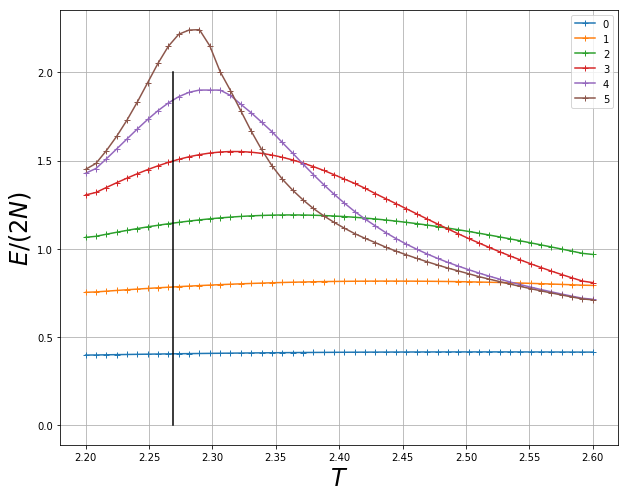

In [30]:
plt.figure(figsize=(10,8))

C = np.zeros_like(E)

for s in range(NSize):
    C[:,s] = np.gradient(E[:,s], Temp)
    plt.plot(Temp, C[:,s], '+-',label='{:d}'.format(s))

plt.plot([Tc, Tc], [0, 2], 'k')
plt.legend()
plt.grid()
plt.xlabel(r'$T$', fontsize=24)
plt.ylabel(r'$E/(2N)$', fontsize=24)
plt.show()

In [31]:
Temp_2 = Temp
C_2 = C

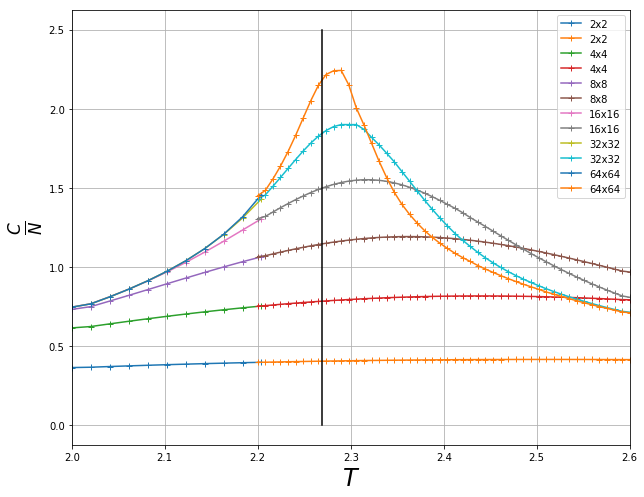

In [32]:
plt.figure(figsize=(10,8))

for s in range(NSize):
#     plt.plot(Temp_0, C_0[:,s], '+-',label='{:d}'.format(s))
    L = 2**(s+1)
    plt.plot(Temp_1[:11], C_1[:11,s], '+-',label='{:d}x{:d}'.format(L, L))    
    plt.plot(Temp_2, C_2[:,s], '+-',label='{:d}x{:d}'.format(L, L))    


plt.plot([Tc, Tc], [0, 2.5], 'k')  
plt.legend()
plt.xlim([2,2.6])
plt.grid()
plt.xlabel(r'$T$', fontsize=24)
plt.ylabel(r'$\frac{C}{N}$', fontsize=24)
# plt.savefig('C.png')
plt.show()

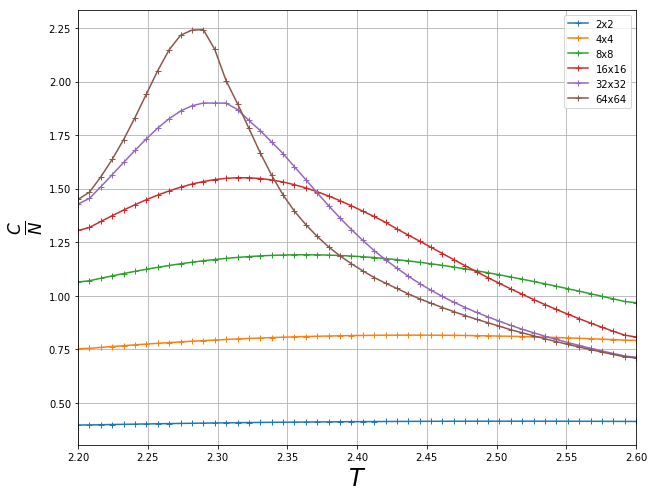

In [34]:
plt.figure(figsize=(10,8))

for s in range(NSize):
#     plt.plot(Temp_0, C_0[:,s], '+-',label='{:d}'.format(s))
    L = 2**(s+1)
#     plt.plot(Temp_1[:11], C_1[:11,s], '+-',label='{:d}x{:d}'.format(L, L))    
    plt.plot(Temp_2, C_2[:,s], '+-',label='{:d}x{:d}'.format(L, L))    


# plt.plot([Tc, Tc], [0, 2.5], 'k')  
plt.legend()
plt.xlim([2.2,2.6])
plt.grid()
plt.xlabel(r'$T$', fontsize=24)
plt.ylabel(r'$\frac{C}{N}$', fontsize=24)
plt.savefig('C.png')
plt.show()